In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt 
# tensor1 = torch.tensor([1, 3, 5, 7, 9])
# tensor2 = torch.tensor([1, 2, 3, 6, 5])

# result = np.intersect1d(tensor1, tensor2)
# result

In [4]:
#f:  s: segmentation map
f_sample=np.load("/home/gaussian-grouping/data/lerf_mask/figurines/language_features/frame_00001_f.npy")
s_sample=np.load("/home/gaussian-grouping/data/lerf_mask/figurines/language_features/frame_00001_s.npy")
 #seg map 은 인덱스 맵인가 => no 그런 개념이 아님 
f_sample.shape, s_sample.shape

((279, 512), (4, 728, 986))

In [2]:
#f:  s: segmentation map
f_sample1=np.load("/home/gaussian-grouping/data/lerf_mask/figurines/language_features_dim3/frame_00001_f.npy")
s_sample1=np.load("/home/gaussian-grouping/data/lerf_mask/figurines/language_features_dim3/frame_00001_s.npy")
f_sample2=np.load("/home/gaussian-grouping/data/lerf_mask/figurines/language_features_dim3/frame_00002_f.npy")
s_sample2=np.load("/home/gaussian-grouping/data/lerf_mask/figurines/language_features_dim3/frame_00002_s.npy")
f_sample3=np.load("/home/gaussian-grouping/data/lerf_mask/figurines/language_features_dim3/frame_00003_f.npy")
s_sample3=np.load("/home/gaussian-grouping/data/lerf_mask/figurines/language_features_dim3/frame_00003_s.npy")
f_sample4=np.load("/home/gaussian-grouping/data/lerf_mask/figurines/language_features_dim3/frame_00004_f.npy")
s_sample4=np.load("/home/gaussian-grouping/data/lerf_mask/figurines/language_features_dim3/frame_00004_s.npy")
f_sample5=np.load("/home/gaussian-grouping/data/lerf_mask/figurines/language_features_dim3/frame_00005_f.npy")
s_sample5=np.load("/home/gaussian-grouping/data/lerf_mask/figurines/language_features_dim3/frame_00005_s.npy")

In [5]:
h,w = s_sample.shape[1:] 
y, x = torch.meshgrid(torch.arange(0, h), torch.arange(0, w))
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
seg_map1 = torch.from_numpy(s_sample1)
feature_map1 = torch.from_numpy(f_sample1)
seg1 = seg_map1[:, y, x].squeeze(-1).long()
mask1 = seg1 != -1
point_feature1 = feature_map1[seg1[0:1]].squeeze(0)

seg_map2 = torch.from_numpy(s_sample2)
feature_map2 = torch.from_numpy(f_sample2)
seg2 = seg_map2[:, y, x].squeeze(-1).long()
mask2 = seg2 != -1
point_feature2 = feature_map2[seg2[0:1]].squeeze(0)

seg_map3 = torch.from_numpy(s_sample3)
feature_map3 = torch.from_numpy(f_sample3)
seg3 = seg_map3[:, y, x].squeeze(-1).long()
mask3 = seg3 != -1
point_feature3 = feature_map3[seg3[0:1]].squeeze(0)

seg_map4 = torch.from_numpy(s_sample4)
feature_map4 = torch.from_numpy(f_sample4)
seg4 = seg_map4[:, y, x].squeeze(-1).long()
mask4 = seg4 != -1
point_feature4 = feature_map4[seg4[0:1]].squeeze(0)

seg_map5 = torch.from_numpy(s_sample5)
feature_map5 = torch.from_numpy(f_sample5)
seg5 = seg_map5[:, y, x].squeeze(-1).long()
mask5 = seg5 != -1
point_feature5 = feature_map1[seg5[0:1]].squeeze(0)

/opt/conda/envs/feature_gs/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


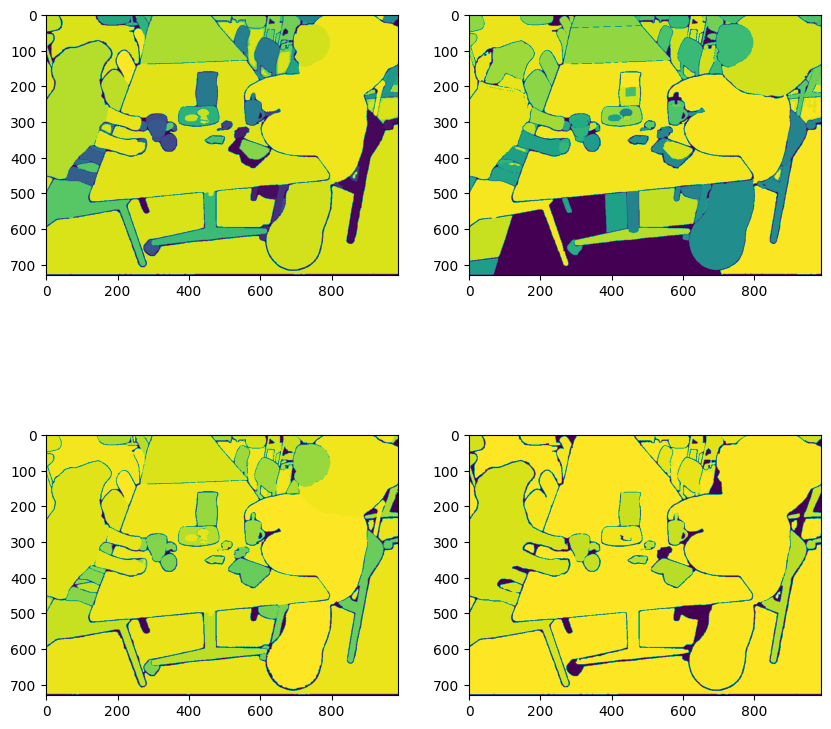

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i in range(4):
    axs[i//2, i%2].imshow(s_sample[i])

In [44]:
#slow fast implementation pre build

from omegaconf import OmegaConf
from scene import Scene, GaussianModel
from copy import deepcopy
import os
from utils.loss_utils import l1_loss, ssim, contrastive_1d_loss
from gaussian_renderer import render
#load config dict
cfg= OmegaConf.load("/home/splat/lang-grouping/lang-grouping/arguments/train/train_config.yaml")

#gaussian load
gaussians = GaussianModel(cfg.dataset.sh_degree)
scene = Scene(cfg.dataset, gaussians)
gaussians.training_setup(cfg.opt)

gaussians_slow = deepcopy(gaussians)
with torch.no_grad():
    for param in gaussians_slow.capture(True):
        if isinstance(param, torch.Tensor):
            param.requires_grad = False

Reading camera 303/303
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  50613


In [42]:

test_cam= scene.getTrainCameras().copy()[1]
cfg.dataset.lf_path = os.path.join(os.path.join(cfg.dataset.source_path, cfg.dataset.language_features_name))
bg_color = [1, 1, 1] if cfg.dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
render_pkg = render(test_cam, gaussians, cfg.pipe, background, cfg.opt)
image, language_feature, viewspace_point_tensor, visibility_filter, radii, objects =\
        render_pkg["render"], render_pkg["language_feature_image"], render_pkg["viewspace_points"], \
        render_pkg["visibility_filter"], render_pkg["radii"], render_pkg["render_object"]
render_pkg_slow = render(test_cam, gaussians_slow, cfg.pipe, background, cfg.opt)
language_feature_slow = render_pkg_slow['language_feature_image']
gt_language_feature, language_feature_mask, seg_map = test_cam.get_language_feature(language_feature_dir=cfg.dataset.lf_path, 
                                                                                            feature_level=cfg.dataset.feature_level,
                                                                                            need_segmap=True)

In [45]:
loss = 0.0
features_fast= language_feature
features_slow = language_feature_slow

h, w = features_fast.shape[1], features_fast.shape[2]
sampled_indices = torch.randint(0, h * w, (1024,))
sampled_indices = sampled_indices.to(objects.device)
indices_fast, indices_slow = torch.split(sampled_indices, 1024//2, dim=0) #non overlap pixels (n_pixels, )
features_fast_flatten = features_fast.reshape(-1, features_fast.shape[0]) #h*w, 3
features_slow_flatten = features_slow.reshape(-1, features_fast.shape[0])



# sampled_features_fast = features_fast_flatten[indices_fast]  # u  : shape must be (N_sample//2,3) TODO error occured point : 
# sampled_features_slow = features_slow_flatten[indices_slow] 

In [46]:
sampled_features_fast = features_fast_flatten[indices_fast]  # u  : shape must be (N_sample//2,3) TODO error occured point : 
sampled_features_slow = features_slow_flatten[indices_slow] 

In [53]:
features_fast_flatten.shape

torch.Size([717808, 3])

In [54]:
indices_fast.shape

torch.Size([512])

In [56]:
sampled_features_fast.shape

torch.Size([512, 3])